# IA de Detecção de Tuberculose 
 Detecção de Tuberculose em pacientes através da análise de Raio X

## 1.Importação de Módulos

In [62]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import os
import kagglehub
import shutil
from keras.src.legacy.preprocessing.image import  ImageDataGenerator
from keras.src.legacy.preprocessing.image import *
import PIL


## 2.Base de Dados

In [2]:
# Caminho da pasta do usuário
home_dir = os.path.expanduser("~")

# Caminho onde os datasets do kagglehub são armazenados
dataset_name = "raddar/tuberculosis-chest-xrays-montgomery"
dataset_folder = dataset_name.replace("/", os.sep)  
dataset_path = os.path.join(home_dir, ".cache", "kagglehub", "datasets", dataset_folder, "versions", "1")

# Verifica se o dataset já foi instalado
if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    print("Baixando o dataset...")
    path = kagglehub.dataset_download("raddar/tuberculosis-chest-xrays-montgomery")
    print("Download concluído! Arquivos em:", path)
else:
    print("Dataset já instalado. Usando arquivos locais em:", dataset_path)

Dataset já instalado. Usando arquivos locais em: C:\Users\ferna\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-montgomery\versions\1


## 3.Criando IA Convolucional

##### 3.1 Separando casos normais e casos de tuberculose

In [3]:
# Lendo arquivo compilado com os resultados médicos
exams_results = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
exams_result_path = os.path.join(dataset_path, exams_results[0])

images = os.path.join(dataset_path, 'images', 'images')

In [4]:
# Criando DataFrame
df_exams_results = pd.read_csv(exams_result_path)
df_exams_results

,study_id,age,gender,findings
0,MCUCXR_0001_0.png,27,Female,normal
1,MCUCXR_0002_0.png,40,Female,normal
2,MCUCXR_0003_0.png,21,Female,normal
3,MCUCXR_0004_0.png,11,Female,normal
4,MCUCXR_0005_0.png,33,Male,normal
...,...,...,...,...
133,MCUCXR_0383_1.png,14,Female,calcified granuloma LUL behind 4th rib anterior
134,MCUCXR_0387_1.png,42,Male,inactive scars RUL
135,MCUCXR_0390_1.png,52,Male,Rt apical scarring. LUL scars and some infiltr...
136,MCUCXR_0393_1.png,30,Female,left pleural effusion; best seen on lateral vi...


In [5]:
# Tratando dados
df_exams_results['findings'] = df_exams_results['findings'].str.strip().str.upper()
df_exams_results

,study_id,age,gender,findings
0,MCUCXR_0001_0.png,27,Female,NORMAL
1,MCUCXR_0002_0.png,40,Female,NORMAL
2,MCUCXR_0003_0.png,21,Female,NORMAL
3,MCUCXR_0004_0.png,11,Female,NORMAL
4,MCUCXR_0005_0.png,33,Male,NORMAL
...,...,...,...,...
133,MCUCXR_0383_1.png,14,Female,CALCIFIED GRANULOMA LUL BEHIND 4TH RIB ANTERIOR
134,MCUCXR_0387_1.png,42,Male,INACTIVE SCARS RUL
135,MCUCXR_0390_1.png,52,Male,RT APICAL SCARRING. LUL SCARS AND SOME INFILTR...
136,MCUCXR_0393_1.png,30,Female,LEFT PLEURAL EFFUSION; BEST SEEN ON LATERAL VI...


In [6]:
# Separando imagens normais e patológicas em duas listas
list_normal = []
list_tuberculosis = []

for i, row in df_exams_results.iterrows():
    name_image = row['study_id']
    if row['findings'] == 'NORMAL':
        list_normal.append(name_image)
    else:
        list_tuberculosis.append(name_image)


In [7]:
# Criando novos diretórios para casos normais e casos patológicos
dir_ai_training = 'AI training images'
dir_normal = 'Normal'
dir_tuberculosis = 'Tuberculosis'

path_ai_training = os.path.join(dataset_path, dir_ai_training)
path_normal = os.path.join(dataset_path, dir_ai_training, dir_normal)
path_tuberculosis = os.path.join(dataset_path, dir_ai_training, dir_tuberculosis)

os.makedirs(path_normal, exist_ok=True)
os.makedirs(path_tuberculosis, exist_ok=True)

In [8]:
# Movendo imagens normais e patológicas para seus respectivos diretórios
for name in list_normal:
    origin = os.path.join(images, name)
    destination = os.path.join(path_normal, name)
    if os.path.exists(origin):
        shutil.move(origin, destination)

for name in list_tuberculosis:
    origin = os.path.join(images, name)
    destination = os.path.join(path_tuberculosis, name)
    if os.path.exists(origin):
        shutil.move(origin, destination)

#### 3.2 Pré-Processamento

In [9]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    path_ai_training,
    target_size=(225,225),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    path_ai_training,
    target_size=(225,225),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 111 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [10]:
print(train_generator.class_indices)


{'Normal': 0, 'Tuberculosis': 1}


#### 3.3 Rede Convolucional Neural

In [11]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(225,225,3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

c:\Users\ferna\codigos\IA_tuberculosis_detector\venv_tf\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## 4.Treinando IA

In [13]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

c:\Users\ferna\codigos\IA_tuberculosis_detector\venv_tf\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 10s/step - accuracy: 0.4862 - loss: 1.4917 - val_accuracy: 0.4074 - val_loss: 0.7833
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 9s/step - accuracy: 0.4778 - loss: 0.7064 - val_accuracy: 0.5926 - val_loss: 0.6637
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.5871 - loss: 0.6625 - val_accuracy: 0.6667 - val_loss: 0.6581
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.6736 - loss: 0.6402 - val_accuracy: 0.6296 - val_loss: 0.5911
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.7397 - loss: 0.5650 - val_accuracy: 0.8519 - val_loss: 0.5761
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.8832 - loss: 0.4619 - val_accuracy: 0.5926 - val_loss: 0.6959
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.8095 - loss: 0.3695 - val_accuracy: 0.7778 - val_loss: 0.5026
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.8599 - loss: 0.2820 - val_accuracy: 0.7407 - val_loss: 0.5458
Epoch 

## 5. Testando IA com Imagens

In [72]:
test_image_path = 'assets/test_image4.jpg'

In [73]:
img = keras.utils.load_img(test_image_path, target_size=(225,225))

img_arrary = keras.utils.img_to_array(img)
img_arrary = np.expand_dims(img_arrary, axis=0) 
img_arrary =img_arrary/255.0

predictions = model.predict(img_arrary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


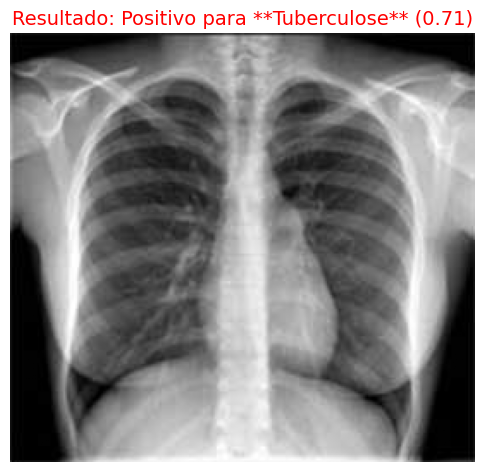

In [ ]:
imagem = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

if predictions[0] > 0.5:
    prediction = (f'Positivo para **Tuberculose** ({predictions[0][0]:.2f})')
else:
    prediction = (f'Negativo para **Tuberculose** ({1 - predictions[0][0]:.2f})')

# Exibe imagem com resultado
plt.figure(figsize=(6,6))
plt.imshow(imagem, cmap='gray')
plt.title(f"Resultado: {prediction}", fontsize=14, color='red' if "Positivo" in prediction else 'green')
plt.axis('off')
plt.show()

## 6. Gráficos e KPI's

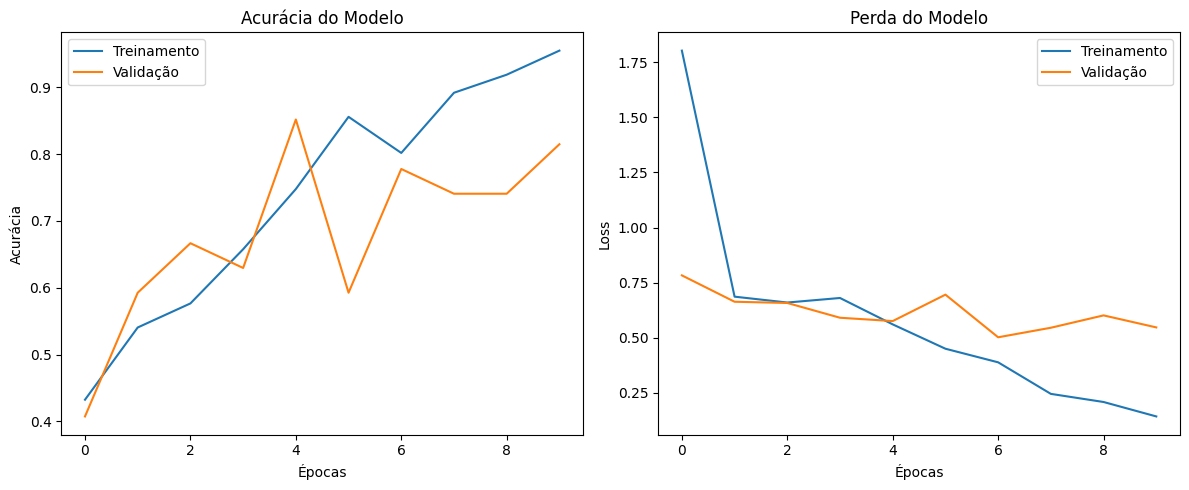

In [ ]:
# Acurácia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
